In [1]:
# ライブラリの読み込み
import os
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def make_filepath_list():
    """
    学習データ、検証データそれぞれのファイルへのパスを格納したリストを返す
    
    Returns
    -------
    train_file_list: list
        学習データファイルへのパスを格納したリスト
    valid_file_list: list
        検証データファイルへのパスを格納したリスト
    """
    train_file_list = []
    valid_file_list = []

    for top_dir in os.listdir('/content/drive/Shareddrives/卒業研究(水都)/picture'):
        file_dir = os.path.join('/content/drive/Shareddrives/卒業研究(水都)/picture', top_dir)
        file_list = os.listdir(file_dir)

        # 各犬種ごとに8割を学習データ、2割を検証データとする
        num_data = len(file_list)
        num_split = int(num_data * 0.8)

        train_file_list += [os.path.join('/content/drive/Shareddrives/卒業研究(水都)/picture', top_dir, file).replace('\\', '/') for file in file_list[:num_split]]
        valid_file_list += [os.path.join('/content/drive/Shareddrives/卒業研究(水都)/picture', top_dir, file).replace('\\', '/') for file in file_list[num_split:]]
    
    return train_file_list, valid_file_list

# 画像データへのファイルパスを格納したリストを取得する
train_file_list, valid_file_list = make_filepath_list()

print('学習データ数 : ', len(train_file_list))
# 先頭3件だけ表示
print(train_file_list[:3])

print('検証データ数 : ', len(valid_file_list))
# 先頭3件だけ表示
print(valid_file_list[:3])

学習データ数 :  727
['/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/2021-07-22 11.16.01 0397.jpg', '/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/2021-07-22 11.16.01 0401.jpg', '/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/2021-07-22 11.16.01 0399.jpg']
検証データ数 :  186
['/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/LINE_ALBUM_マスト_211014_118.jpg', '/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/LINE_ALBUM_マスト_211014_116.jpg', '/content/drive/Shareddrives/卒業研究(水都)/picture/spot2/LINE_ALBUM_マスト_211014_119.jpg']


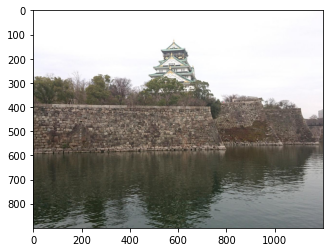

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


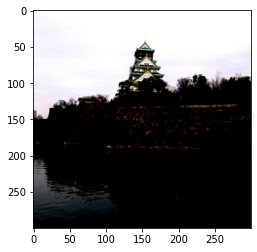

In [ ]:
class ImageTransform(object):
    """
    入力画像の前処理クラス
    画像のサイズをリサイズする
    
    Attributes
    ----------
    resize: int
        リサイズ先の画像の大きさ
    mean: (R, G, B)
        各色チャンネルの平均値
    std: (R, G, B)
        各色チャンネルの標準偏差
    """
    def __init__(self, resize, mean, std):
        self.data_trasnform = {
            'train': transforms.Compose([
                # データオーグメンテーション
                transforms.RandomHorizontalFlip(),
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ]),
            'valid': transforms.Compose([
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_trasnform[phase](img)

# 動作確認
img = Image.open('/content/drive/Shareddrives/卒業研究(水都)/picture/spot1/00000000000000387914_0000007398_4.jpg')

# リサイズ先の画像サイズ
resize = 300

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, 'train')

plt.imshow(img)
plt.show()

plt.imshow(img_transformed.numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
class SpotDataset(data.Dataset):
    """
    犬種のDataseクラス。
    PyTorchのDatasetクラスを継承させる。
    
    Attrbutes
    ---------
    file_list: list
        画像のファイルパスを格納したリスト
    classes: list
        観光地のラベル名
    transform: object
        前処理クラスのインスタンス
    phase: 'train' or 'valid'
        学習か検証化を設定
    """
    def __init__(self, file_list, classes, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.classes = classes
        self.phase = phase
    
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        前処理した画像データのTensor形式のデータとラベルを取得
        """
        # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path)

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)

        #print(self.file_list[index])

        # 画像ラベルをファイル名から抜き出す
        label = self.file_list[index].split('/')[-2]

        # ラベル名を数値に変換
        label = self.classes.index(label)

        return img_transformed, label


# 動作確認
# クラス名
spot_classes = [
    'spot1',  'spot2',
    'spot3', 'spot4', 'spot5'
]

# リサイズ先の画像サイズ
resize = 300

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Datasetの作成
train_dataset = SpotDataset(
    file_list=train_file_list, classes=spot_classes,
    transform=ImageTransform(resize, mean, std),
    phase='train'
)

valid_dataset = SpotDataset(
    file_list=valid_file_list, classes=spot_classes,
    transform=ImageTransform(resize, mean, std),
    phase='valid'
)

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 300, 300])
1


In [ ]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False)

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([64, 3, 300, 300])
tensor([2, 0, 4, 4, 0, 0, 4, 1, 2, 0, 0, 1, 4, 1, 4, 3, 2, 0, 2, 0, 1, 3, 2, 2,
        0, 0, 0, 4, 4, 1, 0, 0, 3, 3, 2, 2, 1, 2, 2, 0, 3, 1, 4, 0, 2, 3, 1, 2,
        2, 1, 0, 4, 3, 1, 3, 0, 0, 0, 3, 4, 0, 4, 0, 1])


In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=128 * 75 * 75, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
    
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)

        x = x.view(-1, 128 * 75 * 75)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

net = Net()
print(net)

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=720000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [ ]:
# エポック数
num_epochs = 1

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'valid']:
        
        if phase == 'train':
            # モデルを訓練モードに設定
            net.train()
        else:
            # モデルを推論モードに設定
            net.eval()
        
        # 損失和
        epoch_loss = 0.0
        # 正解数
        epoch_corrects = 0
        
        # DataLoaderからデータをバッチごとに取り出す
        for inputs, labels in dataloaders_dict[phase]:
            
            # optimizerの初期化
            optimizer.zero_grad()
            
            # 学習時のみ勾配を計算させる設定にする
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                
                # 損失を計算
                loss = criterion(outputs, labels)
                
                # ラベルを予測
                _, preds = torch.max(outputs, 1)
                
                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    # パラメータの更新
                    optimizer.step()
                
                # イテレーション結果の計算
                # lossの合計を更新
                # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                # データ数を掛けることで平均から合計に変換をしている。
                # 損失和は「全データの損失/データ数」で計算されるため、
                # 平均のままだと損失和を求めることができないため。
                epoch_loss += loss.item() * inputs.size(0)
                
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/1
-------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# 予測用のダミーデータ
x = torch.randn([1, 3, 300, 300])
preds = net(x)

In [ ]:
torch.save(net.state_dict(), "/content/drive/Shareddrives/卒業研究(水都)/test.pt")

In [ ]:
import torch
import torchvision.models as models

load_model = Net()
load_model.load_state_dict(torch.load("/content/drive/Shareddrives/卒業研究(水都)/test.pt"))

In [ ]:
load_model.eval()

In [ ]:
print(load_model)

In [ ]:
load_model.eval()

dummy_input = torch.randn(1, 3, 300, 300)
out = load_model(dummy_input)

In [ ]:
print(out)

In [ ]:
import torch
import torchvision.models as models

load_model = Net() 
load_model.load_state_dict(torch.load("/content/drive/Shareddrives/卒業研究(水都)/test.pt"))
load_model.eval()
dummy_input = torch.randn((1, 3, 300, 300))
torch.onnx.export(load_model, dummy_input, "suito.onnx", verbose=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')